# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [1]:
# Basic imports.
import os
import time
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import transforms
from torchvision import datasets
from torchvision import models

from skimage import io
from skimage import transform

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'n_classes': 3, #19,      # Number of classes in segmentation task.
    'pretrained': True,   # Boolean indicating pretraining of backbone.
    'skip': True,         # Boolean indicating presence of Skip Connections.
    'lr': 1e-4,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 8,      # Mini-batch size.
    'w_size': 224,        # Width size for image resizing.
    'h_size': 224,        # Height size for image resizing.
    'show_freq': 5,      # Show predictions in images each show_freq epochs.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


Pré-definindo uma função para iniciação aleatória de pesos.

In [ ]:
# Random initialization for weights and biases.
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

## Métricas usadas para Segmentação Semântica

As métricas mais utilizadas na área de segmentação semântica (e em algumas aplicações em terefas de detecção também) são variações da Intersection over Union ($IoU$), também chamada de **Jaccard**.

![IoU](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Intersection_over_Union_-_poor%2C_good_and_excellent_score.png/300px-Intersection_over_Union_-_poor%2C_good_and_excellent_score.png)

Em tarefas de segmentação/detecção binária, se usa a $IoU$ simples, dada pela fórmula:

$IoU = \frac{\|A\ \cap\ B\|}{\|A\ \cup\ B\|} = \frac{TP}{TP + FP + FN}$.

No caso de problemas multiclasse, usa-se a média do $IoU$ para todas as classes, chamada de mean Intersection over Union ($mIoU$).

A métrica F1 (conhecida também como **Dice**) também é utilizada nesses contextos e é dada pela fórmula:

$F1 = \frac{2TP}{2TP + FP + FN}$.

In [ ]:
# Computing mean Intersection over Union (mIoU).
def evaluate(prds, labs):
    
    int_sum = np.zeros(args['n_classes'], dtype=np.float32)
    uni_sum = np.zeros(args['n_classes'], dtype=np.float32)
    
    for prd, lab in zip(prds, labs):
        
        for c in range(args['n_classes']):

            union = np.sum(lab.ravel() == c)
            if union > 0:
                uni_sum[c] += union
                
                intersection = np.sum(np.logical_and(lab.ravel() == c, prd.ravel() == c))
                int_sum[c] += intersection
    
    return int_sum, uni_sum

# O dataset Pascal VOC 2012

O dataset da competição [Pascal VOC 2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) contém rótulos para detecção e segmentação de imagens, como pode ser visto nas imagens abaixo. Ele e o dataset [COCO](http://cocodataset.org/) são os principais benchmarks da área de Visão Computacional atualmente em tarefas de segmentação semântica e detecção em imagens.

![](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21.jpg)![](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21_class.png)

O Pytorch recentemente lançou um dataloader específico pro Pascal VOC 2012.

In [ ]:
# Root directory for VOC.
root = './'

# Classes left in Pascal VOC 2012.
voc_classes = [0, 89, 147]

# All classes in Pascal VOC 2012.
# voc_classes = [0, 14, 19, 33, 37, 38, 52, 57, 72, 75, 89, 94, 108, 112, 113, 128, 132, 147, 150, 220]

# Custom Image Transform.
class VOCImgTransform(object):
    
    def __call__(self, img):
#         img = transforms.functional.five_crop(img, (args['h_size'], args['w_size']))
        img = transforms.functional.center_crop(img, (args['h_size'], args['w_size']))
        img = transforms.functional.to_tensor(img)
        img = transforms.functional.normalize(img,
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        
#         print('img', img.size(), img.type())
        
        return img

# Custom Target Transform.
class VOCTarTransform(object):
    
    def to_sequential_labels(self, tar):
        
        for i, c in enumerate(voc_classes):
            tar[tar == c] = i
        
        tar[tar > 2] = 0
        return tar
    
    def __call__(self, tar):
        tar = tar.convert(mode='I')
        tar = transforms.functional.center_crop(tar, (args['h_size'], args['w_size']))
        tar = transforms.functional.to_tensor(tar).squeeze().type(torch.int64)
        
        tar = self.to_sequential_labels(tar)
        
        return tar


# Setting datasets.
download_voc = not os.path.isdir('./VOCdevkit/')
train_set = datasets.VOCSegmentation(root,
                                     image_set='train',
                                     download=download_voc,
                                     transform=VOCImgTransform(),
                                     target_transform=VOCTarTransform())
val_set = datasets.VOCSegmentation(root,
                                   image_set='val',
                                   download=False,
                                   transform=VOCImgTransform(),
                                   target_transform=VOCTarTransform())

Exibindo algumas imagens do Pascal VOC 2012 e seus respectivos rótulos a nível de pixel.

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:88: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


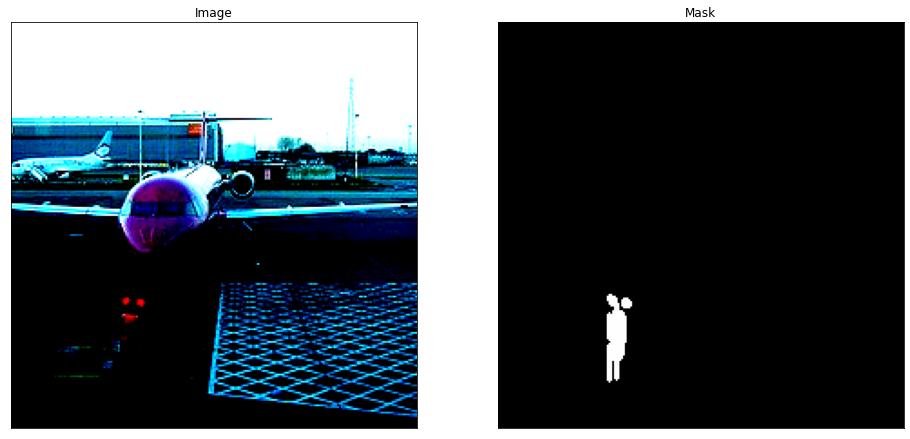

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


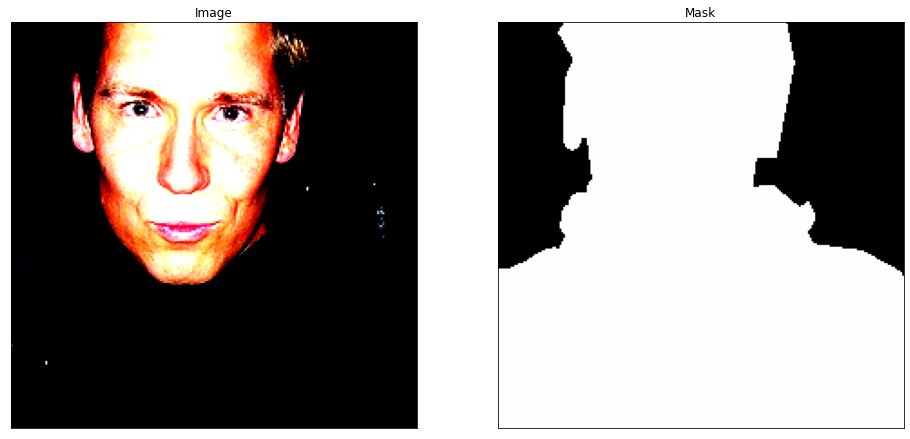

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


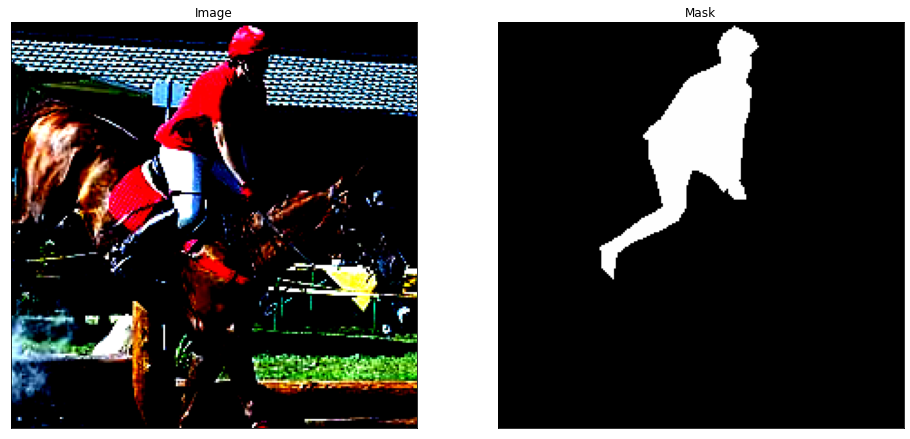

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


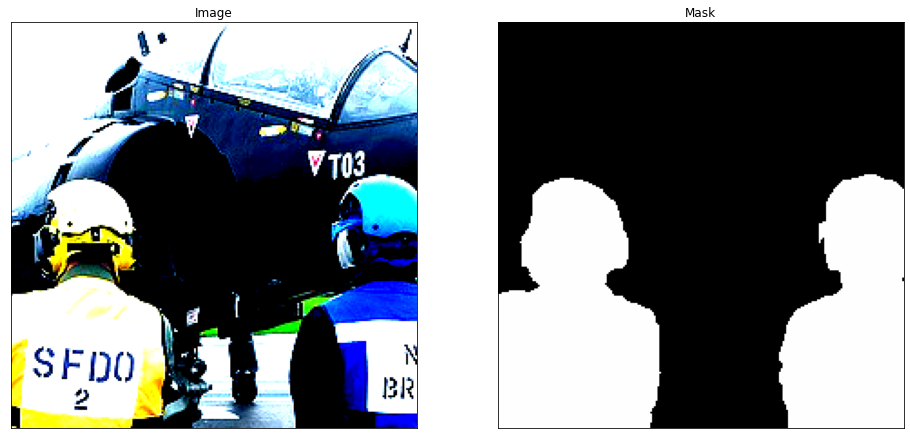

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


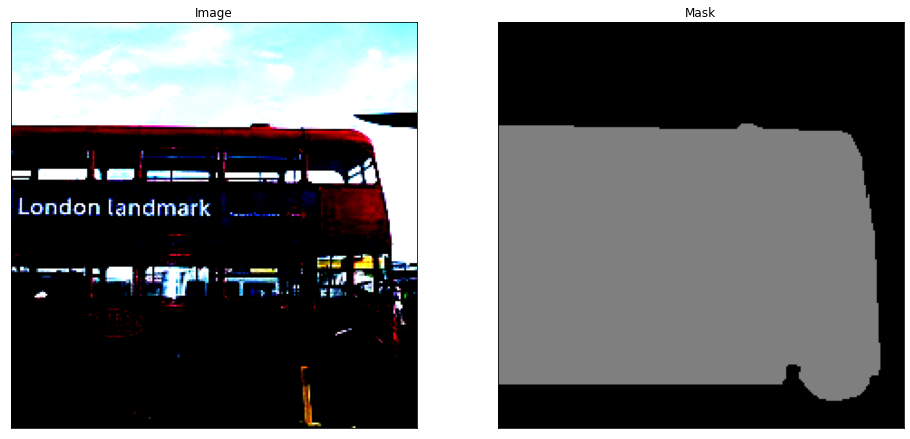

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


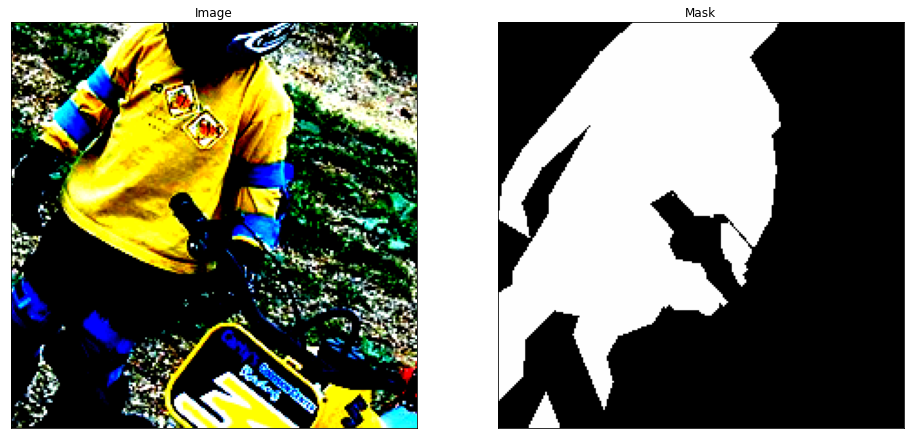

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


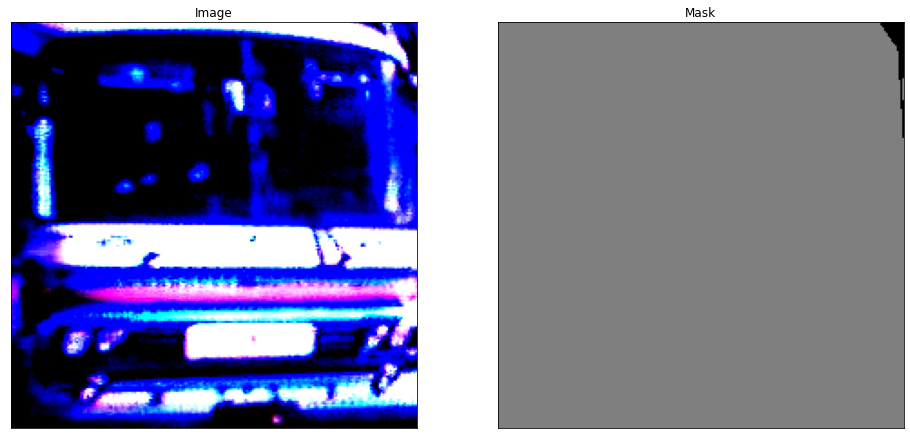

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


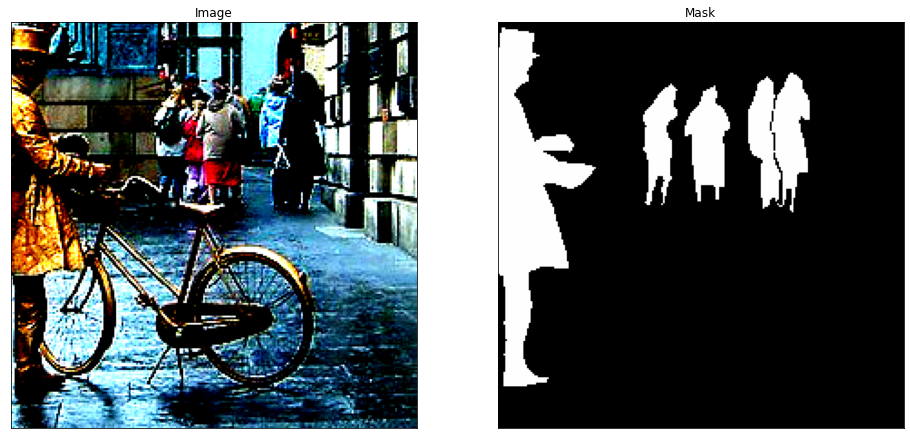

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


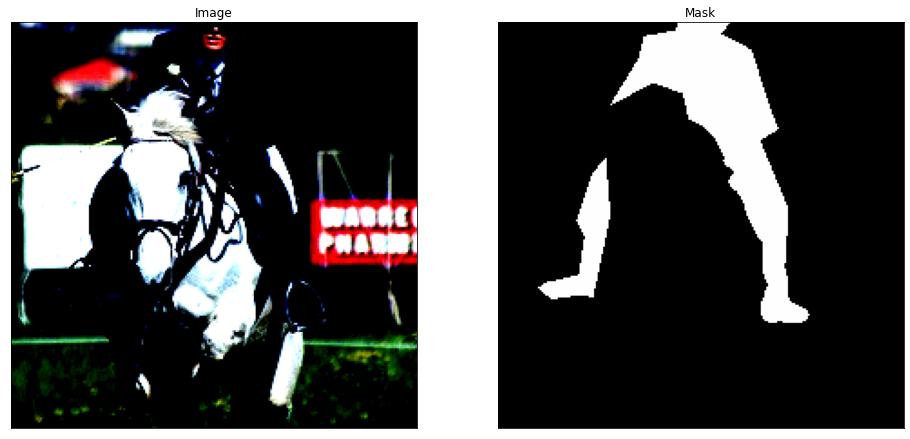

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


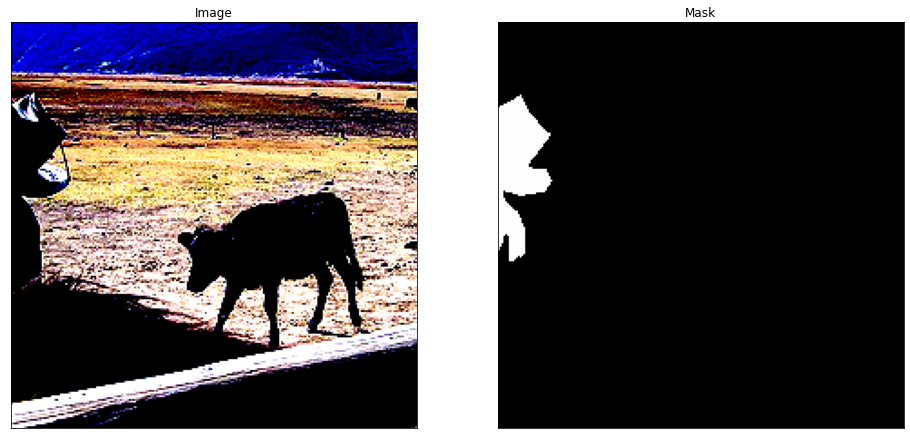

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


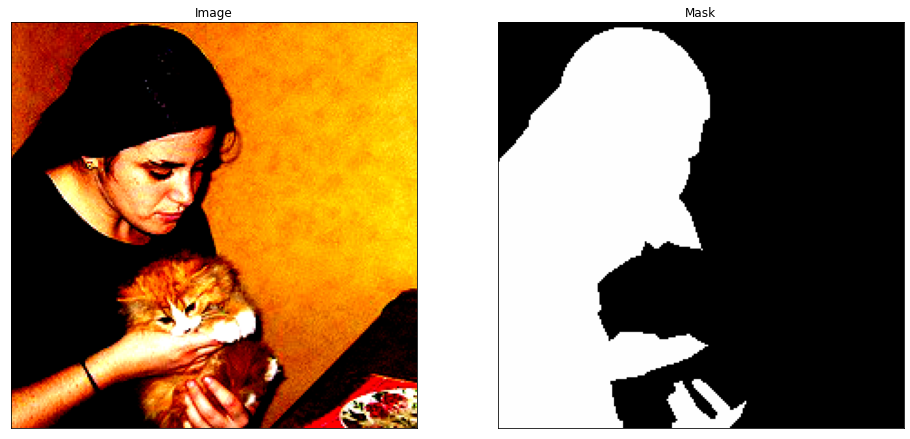

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


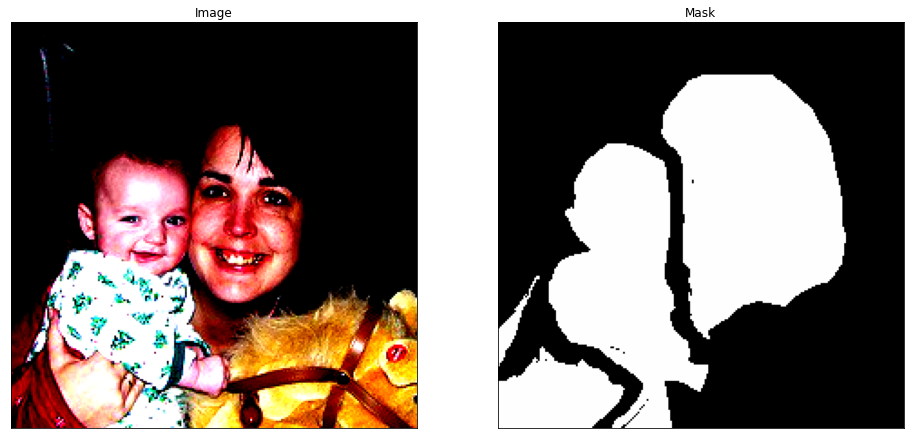

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


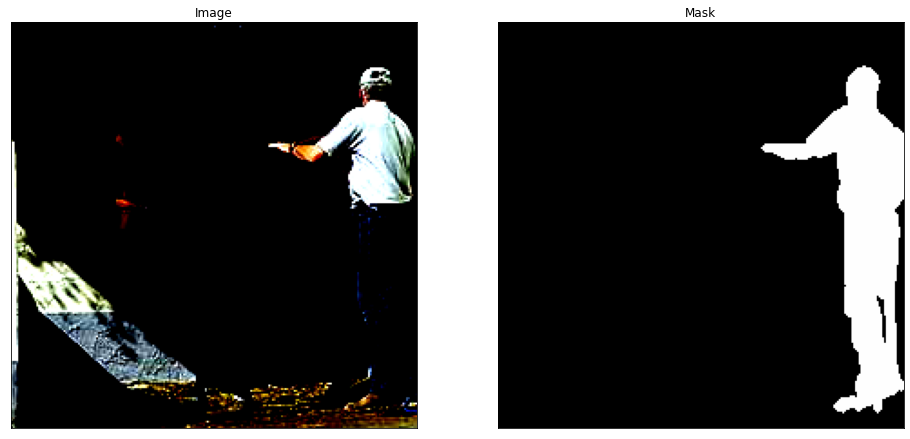

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


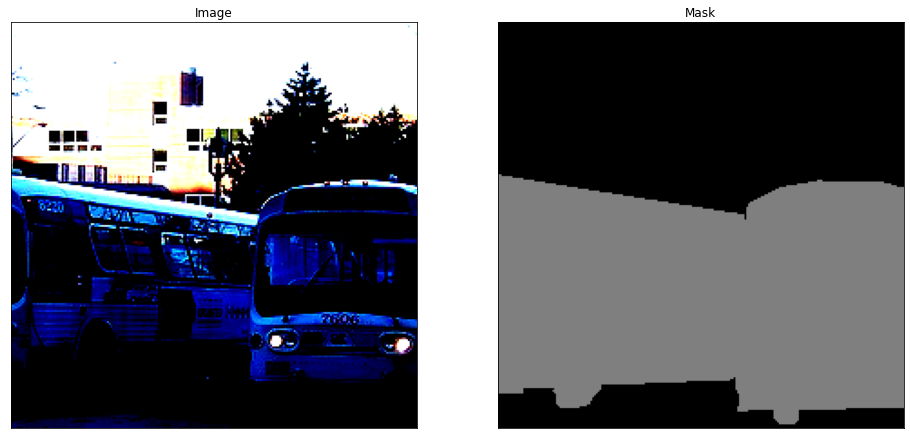

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


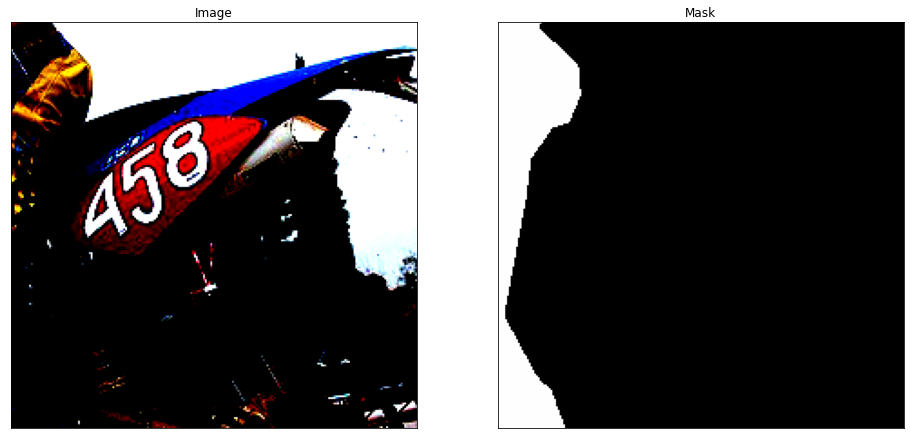

1464 440
1449 439


In [ ]:
# Filtering VOC dataset to iterate only over samples from predefined classes.
train_indices = []
val_indices = []

valid_classes = [0, 1, 2]
    
for i, batch_data in enumerate(train_set):
    
    imgs, labs = batch_data
    
    curr_labels = set(list(labs.numpy().ravel()))
    
    if len([c for c in valid_classes if c in curr_labels]) >= 2: 
    
        train_indices.append(i)
        
        if i < 50:
            
            fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
            ax[0].imshow(imgs.numpy().transpose(1, 2, 0))
            ax[0].set_yticks([])
            ax[0].set_xticks([])
            ax[0].set_title('Image')

            ax[1].imshow(labs.numpy().squeeze() * 127, cmap=plt.get_cmap('gray'),
                         vmin=0, vmax=255)
            ax[1].set_yticks([])
            ax[1].set_xticks([])
            ax[1].set_title('Mask')

            plt.show()
            
for i, batch_data in enumerate(val_set):
    
    imgs, labs = batch_data
    
    curr_labels = set(list(labs.numpy().ravel()))
    
    if len([c for c in valid_classes if c in curr_labels]) >= 2:
    
        val_indices.append(i)

print(len(train_set), len(train_indices))
print(len(val_set), len(val_indices))

Definindo dataloader customizado baseado no subsample do dataset padrão Pascal VOC 2012.

In [ ]:
# Sampler for limiting classes to humans and automobiles.
sampler_train = data.SubsetRandomSampler(train_indices)
sampler_val = data.SubsetRandomSampler(val_indices)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          num_workers=args['num_workers'],
                          sampler=sampler_train)
val_loader = DataLoader(val_set,
                        batch_size=1,
                        num_workers=args['num_workers'],
                        sampler=sampler_val)

# Fully Convolutional Networks

[Fully Convolutional Networks (FCNs)](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) foram propostas em 2015 com o intuito de reaproveitar as CNNs pré-treinadas que já existiam para classificação de imagens como a [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) e a [VGG](https://arxiv.org/abs/1409.1556) em tarefas de **segmentação**. Como temos visto nas últimas aulas, CNNs tradicionais possuem vários blocos convolucionais e de pooling no começo da arquitetura, seguidos de blocos Fully Connected (FC) no fim da rede, os quais realizam a tarefa de inferência. Uma tarefa de segmentação é essencialmente uma classificação de pixels, também conhecida como uma tarefa de **rotulação densa**, contrária à **rotulação esparsa** de uma task de classificação de imagens, em que há um único rótulo por imagem.

![AlexNet](https://miro.medium.com/max/686/0*xPOQ3btZ9rQO23LK.png)

![VGG](https://miro.medium.com/max/700/0*V1muWIDnPVwZUuEv.png)

Também já fomos introduzidos ao conceito de Transfer Learning, que consiste de reaproveitar o conhecimento de um domínio e transferí-lo para outro domínio relativamente semelhante. Transfer Learning pode ser aplicado para transferir o conhecimento obtido num dataset como o ImageNet (para classificação de imagens) para uma tarefa de segmentação num dataset como o Pascal VOC 2012. Como o nome indica, **Fully Convolutional Networks** possuem apenas camadas convolucionais, substituindo as camadas FC por mais blocos convolucionais.

![CNN para FCN](https://www.dropbox.com/s/qsovwd3vuqxkhka/fcns.png?dl=1)

Percebe-se que à medida que as imagens vão passando pelos blocos convolucionais, vão perdendo resolução espacial e sendo representados por cada vez mais canais numa CNN tradicional. No caso das FCNs tradicionais, utiliza-se uma interpolação bilinear simples nos eixos $(H, W)$ nos feature maps que saem da última camada convolucional da CNN tradicional e entram nas novas camadas convolucionais que substituíram as FCs. Por exemplo, no caso da **AlexNet**, os feature maps que saem da última camada convolucional possuem dimensões $(B, C, H, W) = (B, 256, 7, 7)$. Após a interpolação bilinear, esse feature map passa a ter $(B, 256, 224, 224)$, com as últimas dimensões correspondendo à dimensão de entrada $(H_{in}, W_{in}) = (224, 224)$ das imagens do ImageNet.

A última camada de uma FCN (ou de basicamente qualquer outra rede para segmentação semântica) deve ser uma convolução com o número de canais igual ao número de classes. Isso faz com que cada canal de saída sirva como preditor de uma classe numa FCN. A saída da rede deve ter, portanto, as dimensões $(B, \#classes, H_{in}, W_{in})$, de forma que, se for passado um softmax na dimensão 1 (referente a $\#classes$), obtenha-se uma distribuição de probabilidades das classes para cada pixel. Dessa forma, conseguimos transformar uma rede que trata um problema de rotulação esparsa (como uma CNN para classificação) em uma rede que realiza rotulação densa.

FCNs tradicionais partem do pressuposto de que toda a **informação espacial** da imagem original está codificada nos canais que saem das camadas convolucionais da CNN que serve de backbone para a arquitetura. Isso pode não ser verdade principalmente para arquiteturas mais profundas, nas quais há uma discrepância muito grande as dimensões espaciais das imagens de entrada e as dimensões do output da última camada convolucional (i.e. de $(224,224)$ para $(7,7)$). Portanto, no próprio paper das FCNs os autores propuseram pela primeira vez o uso de **Skip Connections** em redes neurais profundas para reconhecimento de imagens. As Skip Connections nas FCNs alimentam as saídas das primeiras convoluções da rede para as últimas camadas inseridas no lugar das antigas camadas FC. É notável que os outputs dessas primeiras camadas possuem resoluções espaciais muito maiores que a saída da última camada convolucional, permitindo que o processo de inferência possa ser feito diretamente com feature maps de maior resolução espacial, resultando em uma segmentação mais detalhada.

![Skip Connections FCNs](https://www.dropbox.com/s/r9cvc14fju7kvpw/skip_connections.png?dl=1)

Skip Connections em FCNs permitem duas coisas:

1.   Treinamento mais eficiente das primeiras camadas por meio de "atalhos" para o backpropagation, assim como nas ResNets;
2.   Incorporação de informação de alto nível semântico das camadas mais profundas com informação de baixo nível semântico, porém com maior resolução espacial no classificador de pixels da Rede.

Na prática, Skip Connections são implementadas como concatenações no eixo dos canais, como mostrado na figura abaixo. Deve-se notar que a camada posterior deve estar preparada para receber a soma da quantidade de canais provenientes da camada anterior com o número de canais da camada que gerou os dados para o Skip Connection.

![Skip FCN](https://www.dropbox.com/s/af4ao1h7kql4uk6/Nets_FCN_Petro.png?dl=1)

# Atividade Prática

1.   Implemente uma FCN com o backbone de uma AlexNet completando o código abaixo. Assim como na aula passada, é preciso definir a arquitetura no método *\_\_init\_\_()*, que, nesse caso, será composta pelas camadas convolucionais da AlexNet concatenadas a mais convoluções, como descrito na seção a cima. Também é necessário implementar o *forward()* que irá descrever o fluxo de dados ao longo da rede. Como segmentação é uma tarefa de classificação de pixels, a loss deve ser novamente a Cross Entropy. A única diferença para a tarefa de classificação da aula passada é que as dimensões espaciais dos labels $(224, 224)$ e das predições da rede $(\#classes, 224, 224)$ devem ser linearizadas para o cálculo da loss, resultado em vetores de dimensões $(224*224)$ e $(\#classes, 224*224)$. Essa linearização deve ser implementada nas funções *train()* e *test()*.

2.   Modifique sua implementação para inserir Skip Connections assim como numa FCN-8s ou uma FCN-16s.

3.   Compare o desempenho de FCNs com e sem Skip Connections e com o backbone estando pré-treinado ou não.

4.   Fazer a mesma adaptação para a VGG 16.

In [ ]:
# class FCN_AlexNet(nn.Module):

#     def __init__(self, num_classes, pretrained=False, skip=False):

#         super(FCN_AlexNet, self).__init__()

#         self.skip = skip
        
#         if self.skip:
            
#             # TO DO: (2.) FCN with Skip Connections (adapted from FCN-8s).
#             feat = models.alexnet(pretrained=pretrained, progress=False).features

#             self.backbone1 = nn.Sequential(
#                 feat[0],
#                 feat[1],
#                 feat[2],
#                 feat[3],
#                 feat[4],
#                 feat[5],
#             )
#             self.backbone2 = nn.Sequential(
#                 feat[6],
#                 feat[7],
#                 feat[8],
#                 feat[9],
#                 feat[10],
#                 feat[11],
#                 feat[12],
#             )

#             self.classifier = nn.Sequential(
#                 nn.Conv2d(256 + 192, 64, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(),
#                 nn.Dropout2d(0.5),
#                 nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
#             )
#         else:
            
#             # TO DO: (1.) FCN with Skip Connections.
#             self.backbone = models.alexnet(pretrained=pretrained, progress=False).features

#             self.classifier = nn.Sequential(
#                 nn.Conv2d(256, 64, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(),
#                 nn.Dropout2d(0.5),
#                 nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
#             )
        
#         if not pretrained:
#             initialize_weights(self)

#     def forward(self, x):

#         if self.skip:
            
#             # TO DO: (2.) Forward on FCN with Skip Connections.
#             feat1 = self.backbone1(x)
#             feat2 = self.backbone2(feat1)

#             feat = torch.cat([F.upsample(feat1, x.size()[2:], mode='bilinear'),
#                               F.upsample(feat2, x.size()[2:], mode='bilinear')], 1)

#         else:

#             # TO DO: (1.) Forward on FCN without Skip Connections.
#             feat = self.backbone(x)

#             feat = F.upsample(feat, x.size()[2:], mode='bilinear')

#         output = self.classifier(feat)

#         return output
        
# net = FCN_AlexNet(args['n_classes'],
#                   pretrained=args['pretrained'],
#                   skip=args['skip']).to(args['device'])

# print(net)

In [ ]:
class FCN_VGG16(nn.Module):

    def __init__(self, num_classes, pretrained=False, skip=False):

        super(FCN_VGG16, self).__init__()

        self.skip = skip
        
        if self.skip:
            
            # TO DO: (2.) FCN with Skip Connections (adapted from FCN-8s).
            feat = models.vgg16_bn(pretrained=pretrained, progress=False).features

            self.backbone1 = nn.Sequential(*feat[:33])
            self.backbone2 = nn.Sequential(*feat[33:])

            self.classifier = nn.Sequential(
                nn.Conv2d(512 + 512, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout2d(0.5),
                nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
            )
        else:
            
            # TO DO: (1.) FCN without Skip Connections.
            self.backbone = models.vgg16_bn(pretrained=pretrained, progress=False).features

            self.classifier = nn.Sequential(
                nn.Conv2d(512, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout2d(0.5),
                nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
            )
        
        if not pretrained:
            initialize_weights(self)

    def forward(self, x):

        if self.skip:
            
            # TO DO: (2.) Forward on FCN with Skip Connections.
            feat1 = self.backbone1(x)
            feat2 = self.backbone2(feat1)

            feat = torch.cat([F.upsample(feat1, x.size()[2:], mode='bilinear'),
                              F.upsample(feat2, x.size()[2:], mode='bilinear')], 1)

        else:

            # TO DO: (1.) Forward on FCN without Skip Connections.
            feat = self.backbone(x)

            feat = F.upsample(feat, x.size()[2:], mode='bilinear')

        output = self.classifier(feat)

        return output
        
net = FCN_VGG16(args['n_classes'],
                pretrained=args['pretrained'],
                skip=args['skip']).to(args['device'])

print(net)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


FCN_VGG16(
  (backbone1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(1

In [ ]:
# Setting optimizer.
if args['pretrained']:
    
    if args['skip']:
        
        # Skip Connections + pretrained.
        optimizer = optim.Adam([{'params': net.backbone1.parameters(), 'lr': args['lr'] * 0.1},
                                {'params': net.backbone2.parameters(), 'lr': args['lr'] * 0.1},
                                {'params': net.classifier.parameters()}],
                               lr=args['lr'],
                               weight_decay=args['weight_decay'],
                               betas=(args['momentum'], 0.999))

    else:
        
        # No Skip Connections + pretrained.
        optimizer = optim.Adam([{'params': net.backbone.parameters(), 'lr': args['lr'] * 0.1},
                                {'params': net.classifier.parameters()}],
                               lr=args['lr'],
                               weight_decay=args['weight_decay'],
                               betas=(args['momentum'], 0.999))
else:
    
    if args['skip']:

        # Skip Connections + from scratch.
        optimizer = optim.Adam([{'params': net.backbone1.parameters()},
                                {'params': net.backbone2.parameters()},
                                {'params': net.classifier.parameters()}],
                               lr=args['lr'],
                               weight_decay=args['weight_decay'],
                               betas=(args['momentum'], 0.999))
        
    else:
        
        # No Skip Connections + from scratch.
        optimizer = optim.Adam([{'params': net.backbone.parameters()},
                                {'params': net.classifier.parameters()}],
                               lr=args['lr'],
                               weight_decay=args['weight_decay'],
                               betas=(args['momentum'], 0.999))

In [ ]:
# Setting loss.
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.1, 1.0, 1.0])).to(args['device'])

In [ ]:
# Training function.
def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    int_all = np.asarray(args['n_classes'], dtype=np.float32)
    uni_all = np.asarray(args['n_classes'], dtype=np.float32)

    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # TO DO: Forwarding through network.
        outs = net(inps)

        # TO DO: Computing loss.
        loss = criterion(outs.view(outs.size(0), outs.size(1), -1),
                         labs.view(labs.size(0), -1))

        # Computing backpropagation.
        loss.backward()
        optimizer.step()

        # Obtaining predictions.
        prds = outs.data.max(1)[1].squeeze_(1).squeeze(0).cpu().numpy()
        
        # Appending metrics for epoch error calculation.
        int_sum, uni_sum = evaluate([prds],
                                    [labs.detach().squeeze(0).cpu().numpy()])

        int_all = int_all + int_sum
        uni_all = uni_all + uni_sum

        # Updating loss meter.
        train_loss.append(loss.data.item())

    toc = time.time()
    
    # Transforming list into numpy array.
    train_loss = np.asarray(train_loss)
    
    # Computing error metrics for whole epoch.
    iou = 0
    iou = np.divide(int_all, uni_all)
#     print(iou)

    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [miou %.4f], [time %.4f]' % (
        epoch, train_loss.mean(), train_loss.std(), iou[1:].mean(), (toc - tic)))
    print('-------------------------------------------------------------------')

def validate(val_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    val_loss = []

    int_all = np.asarray(args['n_classes'], dtype=np.float32)
    uni_all = np.asarray(args['n_classes'], dtype=np.float32)

    # Iterating over batches.
    for i, batch_data in enumerate(val_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # TO DO: Forwarding through network.
        outs = net(inps)

        # TO DO: Computing loss.
        loss = criterion(outs.view(outs.size(0), outs.size(1), -1),
                         labs.view(labs.size(0), -1))

        # Obtaining predictions.
        prds = outs.data.max(1)[1].squeeze_(1).squeeze(0).cpu().numpy()

        # Appending metrics for epoch error calculation.
        int_sum, uni_sum = evaluate([prds],
                                    [labs.detach().squeeze(0).cpu().numpy()])

        int_all = int_all + int_sum
        uni_all = uni_all + uni_sum

        # Updating loss meter.
        val_loss.append(loss.data.item())
        
        if i == 0 and epoch % args['show_freq'] == 0:
            
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            
            ax[0].imshow(inps[0].detach().cpu().numpy().transpose(1, 2, 0))
            ax[0].set_yticks([])
            ax[0].set_xticks([])
            ax[0].set_title('Image')
            
            ax[1].imshow(prds * 127,
                         cmap=plt.get_cmap('gray'),
                         vmin=0, vmax=255)
            ax[1].set_yticks([])
            ax[1].set_xticks([])
            ax[1].set_title('Prediction')
            
            ax[2].imshow(labs[0].detach().squeeze(0).cpu().numpy() * 127,
                         cmap=plt.get_cmap('gray'),
                         vmin=0, vmax=255)
            ax[2].set_yticks([])
            ax[2].set_xticks([])
            ax[2].set_title('True Label')
            
            plt.show()

    toc = time.time()
    
    # Transforming list into numpy array.
    val_loss = np.asarray(val_loss)
    
    # Computing error metrics for whole epoch.
    iou = 0
    iou = np.divide(int_all, uni_all)
#     print(iou)

    # Printing test epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [miou %.4f], [time %.4f]' % (
        epoch, val_loss.mean(), val_loss.std(), iou[1:].mean(), (toc - tic)))
    print('-------------------------------------------------------------------')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


-------------------------------------------------------------------
[epoch 1], [train loss 0.5614 +/- 0.2439], [miou 0.8918], [time 68.2692]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 1], [test loss 0.4437 +/- 0.2667], [miou 0.9617], [time 10.2881]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train loss 0.3596 +/- 0.0807], [miou 0.9426], [time 65.2398]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [test loss 0.3590 +/- 0.2361], [miou 0.9534], [time 9.8685]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train loss 0.3108 +/- 0.0888], [miou 0.9556], [time 65.2199]
--------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


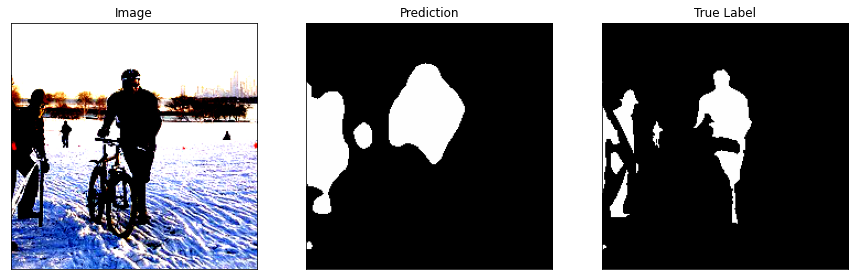

-------------------------------------------------------------------
[epoch 5], [test loss 0.2768 +/- 0.2156], [miou 0.9470], [time 10.1081]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train loss 0.2257 +/- 0.0644], [miou 0.9679], [time 65.1366]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [test loss 0.2725 +/- 0.2082], [miou 0.9351], [time 10.0092]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train loss 0.2087 +/- 0.0785], [miou 0.9668], [time 65.2259]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [test loss 0.2719 +/- 0.2238], [miou 0.9414], [time 10.0687]
--------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


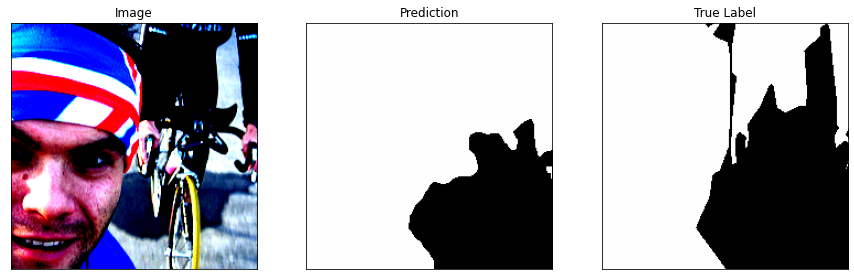

-------------------------------------------------------------------
[epoch 10], [test loss 0.2676 +/- 0.2326], [miou 0.9389], [time 10.1414]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 11], [train loss 0.1695 +/- 0.0656], [miou 0.9693], [time 65.2397]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 11], [test loss 0.2551 +/- 0.2108], [miou 0.9266], [time 9.9719]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 12], [train loss 0.1539 +/- 0.0787], [miou 0.9785], [time 65.1343]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 12], [test loss 0.2558 +/- 0.2248], [miou 0.9164], [time 9.8787]
-----------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


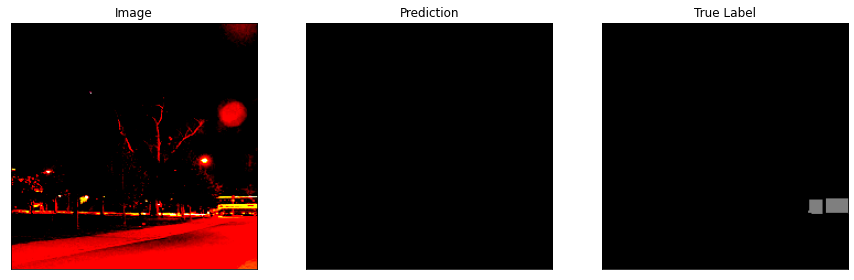

-------------------------------------------------------------------
[epoch 15], [test loss 0.2559 +/- 0.2397], [miou 0.9270], [time 10.0680]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 16], [train loss 0.1161 +/- 0.0490], [miou 0.9856], [time 65.1960]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 16], [test loss 0.2644 +/- 0.2598], [miou 0.9138], [time 9.9887]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 17], [train loss 0.1101 +/- 0.0409], [miou 0.9854], [time 65.1220]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 17], [test loss 0.2664 +/- 0.2620], [miou 0.9067], [time 9.8997]
-----------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


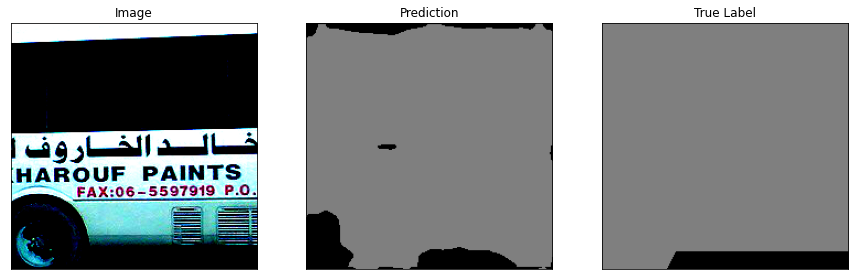

-------------------------------------------------------------------
[epoch 20], [test loss 0.2811 +/- 0.3132], [miou 0.8852], [time 10.0652]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 21], [train loss 0.1055 +/- 0.0618], [miou 0.9896], [time 65.1254]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 21], [test loss 0.2852 +/- 0.2980], [miou 0.9098], [time 9.8828]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 22], [train loss 0.0882 +/- 0.0310], [miou 0.9932], [time 65.0934]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 22], [test loss 0.2981 +/- 0.3179], [miou 0.9043], [time 9.8558]
-----------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


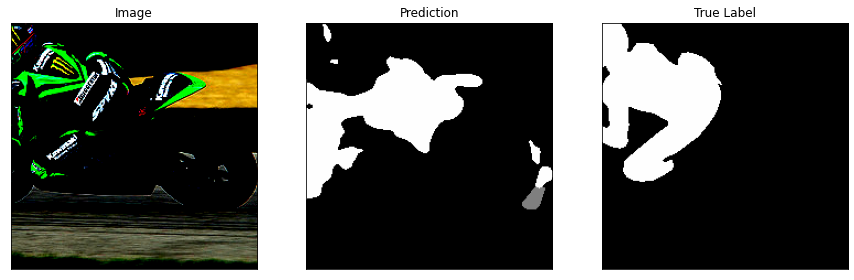

-------------------------------------------------------------------
[epoch 25], [test loss 0.2922 +/- 0.3292], [miou 0.8981], [time 10.0672]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 26], [train loss 0.0861 +/- 0.0451], [miou 0.9910], [time 65.0118]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 26], [test loss 0.2928 +/- 0.3308], [miou 0.8911], [time 9.8533]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 27], [train loss 0.0813 +/- 0.0264], [miou 0.9921], [time 65.0670]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 27], [test loss 0.3000 +/- 0.3324], [miou 0.8995], [time 10.0779]
----------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


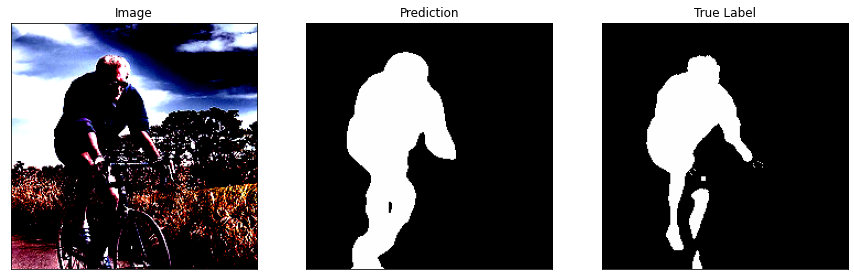

-------------------------------------------------------------------
[epoch 30], [test loss 0.3181 +/- 0.3672], [miou 0.8845], [time 10.0973]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 31], [train loss 0.0738 +/- 0.0245], [miou 0.9928], [time 65.0762]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 31], [test loss 0.3218 +/- 0.3830], [miou 0.8737], [time 9.8674]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 32], [train loss 0.0776 +/- 0.0343], [miou 0.9883], [time 65.0692]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 32], [test loss 0.3283 +/- 0.3884], [miou 0.8846], [time 10.0027]
----------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


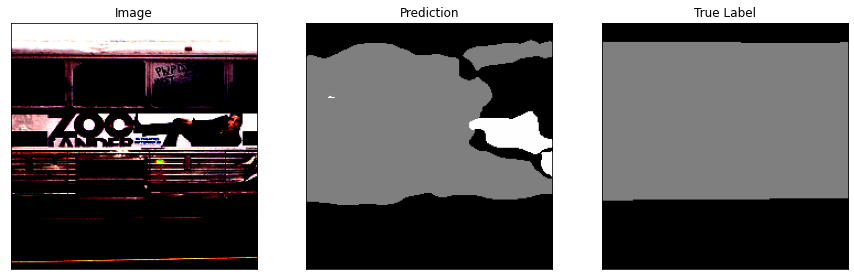

-------------------------------------------------------------------
[epoch 35], [test loss 0.3335 +/- 0.4008], [miou 0.8836], [time 10.3844]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 36], [train loss 0.0699 +/- 0.0290], [miou 0.9933], [time 65.1244]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 36], [test loss 0.3156 +/- 0.3518], [miou 0.9031], [time 9.8668]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 37], [train loss 0.0692 +/- 0.0313], [miou 0.9911], [time 65.0073]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 37], [test loss 0.3137 +/- 0.3666], [miou 0.8912], [time 9.9143]
-----------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


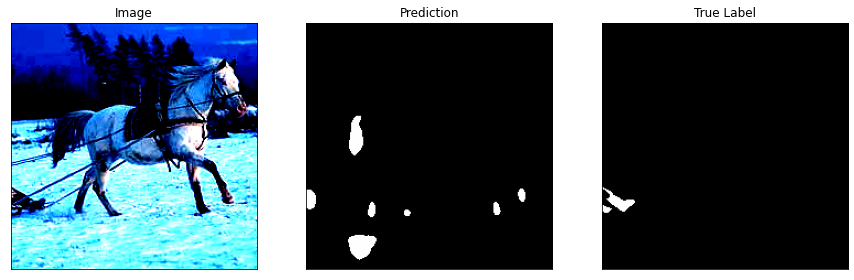

-------------------------------------------------------------------
[epoch 40], [test loss 0.3153 +/- 0.3740], [miou 0.8862], [time 10.0477]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 41], [train loss 0.0675 +/- 0.0277], [miou 0.9918], [time 65.0675]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 41], [test loss 0.3289 +/- 0.4093], [miou 0.8715], [time 9.9944]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 42], [train loss 0.0637 +/- 0.0178], [miou 0.9937], [time 65.0539]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 42], [test loss 0.3316 +/- 0.4118], [miou 0.8798], [time 9.8451]
-----------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


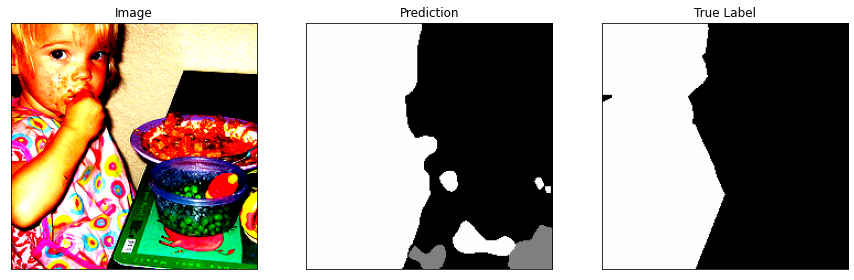

-------------------------------------------------------------------
[epoch 45], [test loss 0.3467 +/- 0.4184], [miou 0.8892], [time 10.0639]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 46], [train loss 0.0579 +/- 0.0160], [miou 0.9945], [time 65.0672]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 46], [test loss 0.3251 +/- 0.4016], [miou 0.8910], [time 9.8478]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 47], [train loss 0.0586 +/- 0.0182], [miou 0.9949], [time 65.0156]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 47], [test loss 0.3263 +/- 0.3837], [miou 0.8966], [time 9.9147]
-----------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


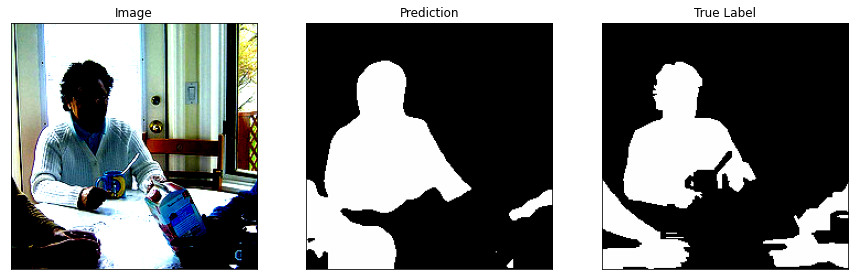

-------------------------------------------------------------------
[epoch 50], [test loss 0.3946 +/- 0.5158], [miou 0.8496], [time 10.0938]
-------------------------------------------------------------------


In [ ]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    validate(val_loader, net, criterion, epoch)